# LLM CoT 推理分析报告

本 Notebook 用于分析 `main.py` 脚本生成的实验结果，并根据项目方案进行可视化。

/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21153 (\N{CJK UNIFIED IDEOGRAPH-52A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from fon

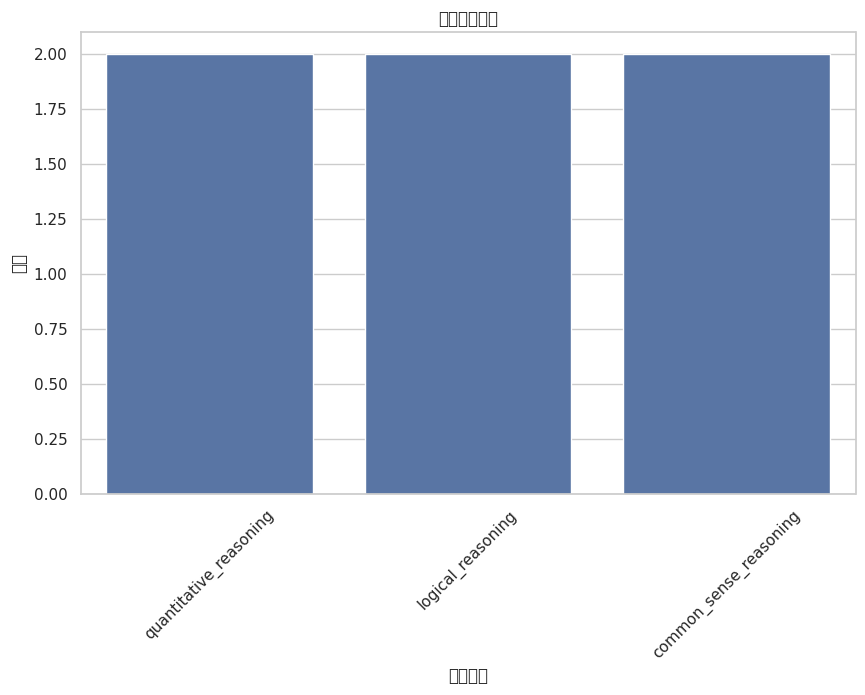

In [11]:
# 可视化任务类型分布
# 将宽表格转换为长表格，每一行代表一个 (task_type, question)
df_tasks = df.melt(value_name='question', var_name='task_type').dropna(subset=['question'])

plt.figure(figsize=(10, 6))
sns.countplot(data=df_tasks, x='task_type', order=df_tasks['task_type'].value_counts().index)
plt.title('任务类型分布')
plt.xlabel('任务类型')
plt.ylabel('数量')
plt.xticks(rotation=45)
plt.show()

/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21153 (\N{CJK UNIFIED IDEOGRAPH-52A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from fon

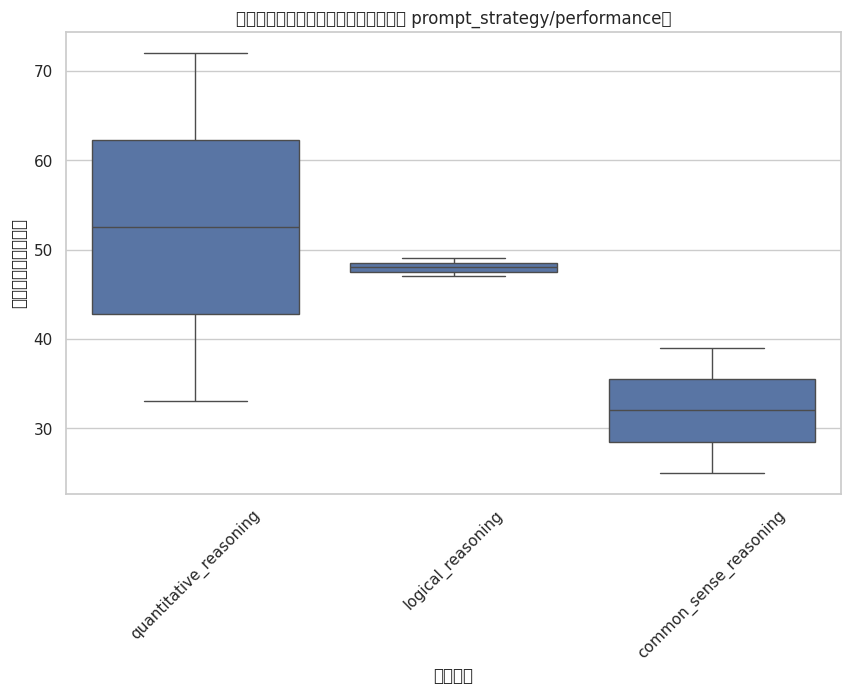

In [12]:

# 如果没有 prompt_strategy / performance 列，改为按任务类型展示问题长度分布（作为替代分析）
# 优先使用已存在的 df_tasks（包含 task_type 和 question 字段）
if 'df_tasks' in globals():
	tasks_df = df_tasks.copy()
else:
	tasks_df = df.melt(value_name='question', var_name='task_type').dropna(subset=['question'])
# 提取问题文本并计算长度
def _get_q_text(q):
	if isinstance(q, dict):
		return q.get('question', '')
	return str(q)
tasks_df['q_text'] = tasks_df['question'].apply(_get_q_text)
tasks_df['q_len'] = tasks_df['q_text'].str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=tasks_df, x='task_type', y='q_len',
			order=tasks_df['task_type'].value_counts().index)
plt.title('按任务类型的问题长度分布（替代：无 prompt_strategy/performance）')
plt.xlabel('任务类型')
plt.ylabel('问题长度（字符数）')
plt.xticks(rotation=45)
plt.show()

## 3. 使用裁判 LLM 进行深度分析

为了更深入地理解模型在推理过程中的具体表现，我们引入一个强大的“裁判 LLM”来评估模型生成的 CoT（思维链）路径的正确性。

**评估流程**:
1.  **子集选择**: 从测试结果中随机抽取一部分使用 CoT 策略的样本。
2.  **裁判评估**: 使用一个高性能的 LLM（例如 `Qwen/Qwen3-32B`）作为裁判，对每个样本的 CoT 路径进行评估。
3.  **标注内容**: 裁判模型将重点标注两个方面：
    - **步骤正确性 (Step Correctness)**: 推理路径中有多少步骤是逻辑正确的。
    - **错误类型 (Error Type)**: 如果存在错误，其主要类型是什么（例如：算术错误、逻辑跳跃等）。
4.  **可视化分析**: 对裁判结果进行可视化，以洞察不同模型的常见失败模式。

In [16]:
# 尝试以可编辑模式安装上级工程（如果已配置为可安装包），以避免 ModuleNotFoundError
# 该命令在 Jupyter 中执行；如果不是可安装包也不会破坏环境
%pip install -e ..
%pip install ipywidgets

import sys
import os
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure parent project dir is on sys.path so local `src` package is importable
proj_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

# 导入我们刚刚创建的 JudgeLLM
try:
    from src.judge_llm import JudgeLLM
except ModuleNotFoundError as e:
    # 如果仍然导入失败，打印当前 sys.path 以便排查
    print("Failed to import 'src.judge_llm'. Current sys.path:", sys.path)
    raise e

# 初始化 tqdm 以在 pandas 中使用
tqdm.pandas()

# 加载实验结果
try:
    df = pd.read_csv('../results.csv')
except FileNotFoundError:
    print("错误: results.csv 未找到。请先运行 src/main.py 生成实验结果。")
    # 创建一个空的DataFrame以避免后续代码出错
    df = pd.DataFrame(columns=['model', 'strategy', 'question', 'standard_answer', 'model_output'])

# 筛选出使用CoT策略的样本
cot_df = df[df['strategy'].str.contains('cot', na=False)].copy()

# --- 子集选择 ---
# 为了提高效率，我们只评估一小部分样本（例如，随机抽取50个）
# 如果样本总数少于50，则全部评估
sample_size = min(50, len(cot_df))
if sample_size > 0:
    evaluation_sample = cot_df.sample(n=sample_size, random_state=42)
else:
    evaluation_sample = cot_df # 如果没有CoT样本，则为空DataFrame

print(f"将对 {len(evaluation_sample)} 个CoT样本进行深度评估...")

# 初始化裁判LLM
if not evaluation_sample.empty:
    judge = JudgeLLM()

    # --- 裁判评估 ---
    # 使用tqdm.progress_apply来显示进度条
    def apply_evaluation(row):
        return judge.evaluate_cot_path(
            question=row['question'],
            standard_answer=row['standard_answer'],
            model_cot_output=row['model_output']
        )

    print("裁判LLM正在评估中，请稍候...")
    eval_results = evaluation_sample.progress_apply(apply_evaluation, axis=1)

    # 将评估结果（一个Series的字典）转换为DataFrame
    eval_df = pd.json_normalize(eval_results)

    # 将评估结果与原始样本数据合并
    evaluation_sample.reset_index(drop=True, inplace=True)
    eval_df.reset_index(drop=True, inplace=True)
    detailed_analysis_df = pd.concat([evaluation_sample, eval_df], axis=1)

    print("评估完成！")
    display(detailed_analysis_df.head())
else:
    print("没有找到使用CoT策略的样本进行评估。")
    detailed_analysis_df = pd.DataFrame() # 创建空DataFrame


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Obtaining file:///home/nyz/AIAA2205PROJECT/llm-cot-siliconflow-py
ERROR: file:///home/nyz/AIAA2205PROJECT/llm-cot-siliconflow-py does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.6 MB/s  0:00:00 eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 6.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]


/home/nyz/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: you may need to restart the kernel to use updated packages.
将对 12 个CoT样本进行深度评估...
裁判LLM正在评估中，请稍候...


100%|██████████| 12/12 [01:14<00:00,  6.19s/it]

评估完成！


,model,task_type,question_id,question,standard_answer,strategy,prompt,model_output,step_correctness,error_type
0,Qwen/Qwen2-7B-Instruct,common_sense_reasoning,common_002,小红在切洋葱时流泪了，她可以做什么来减轻这种不适？,她可以尝试将洋葱冷藏后再切，或者在通风良好的地方切，也可以戴上护目镜。,zero_shot_cot,请回答以下问题，逐步思考，最后给出答案。\n问题: 小红在切洋葱时流泪了，她可以做什么来减轻...,1. **理解原因**：首先，我们需要理解为什么在切洋葱时会流泪。这种现象是因为洋葱中含有一...,4/7,premise_omission
1,Qwen/Qwen2-7B-Instruct,common_sense_reasoning,common_001,如果我想把湿衣服晾干，并且外面正在下雨，我应该把衣服放在室内还是室外？为什么？,应该放在室内。因为室内空气相对干燥，可以帮助水分蒸发，而室外下雨会使衣服更湿。,few_shot_cot,示例1:\n问题: 一个篮子里有5个苹果，又放进去了3个，后来吃掉了2个，篮子里还剩几个苹果...,思考过程: 要让湿衣服晾干，需要湿衣服与空气接触并且空气需要是流动的。下雨时，室外的空气通常...,4/5,premise_omission
2,Qwen/Qwen2-7B-Instruct,quantitative_reasoning,quant_001,一个农场里有鸡和兔子共35个头，94只脚。请问鸡和兔子各有多少只？,鸡有23只，兔子有12只。,zero_shot_cot,请回答以下问题，逐步思考，最后给出答案。\n问题: 一个农场里有鸡和兔子共35个头，94只脚...,为解决这个问题，我们可以设定两个变量来表示鸡和兔子的数量。设鸡的数量为x，兔子的数量为y。\...,5/5,correct
3,Qwen/Qwen2-7B-Instruct,common_sense_reasoning,common_001,如果我想把湿衣服晾干，并且外面正在下雨，我应该把衣服放在室内还是室外？为什么？,应该放在室内。因为室内空气相对干燥，可以帮助水分蒸发，而室外下雨会使衣服更湿。,zero_shot_cot,请回答以下问题，逐步思考，最后给出答案。\n问题: 如果我想把湿衣服晾干，并且外面正在下雨，...,如果想要把湿衣服晾干，应该把衣服放在室内。\n\n原因如下：\n\n1. **温度和湿度的影...,2/3,logical_fallacy
4,Qwen/Qwen2-7B-Instruct,logical_reasoning,logic_001,前提A：所有哺乳动物都是温血动物。前提B：鲸鱼是哺乳动物。请问根据这两个前提可以得出什么结论？,鲸鱼是温血动物。,few_shot_cot,示例1:\n问题: 前提A：所有的人都会死。前提B：苏格拉底是人。结论是什么？\n思考过程:...,根据前提A“所有哺乳动物都是温血动物”和前提B“鲸鱼是哺乳动物”，我们可以得出结论：鲸鱼是温...,1/1,correct


### 4.1 错误类型分布分析

对裁判 LLM 标注的错误类型进行可视化，以分析不同模型在推理失败时的主要原因。

/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38169 (\N{CJK UNIFIED IDEOGRAPH-9519}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nyz/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from fon

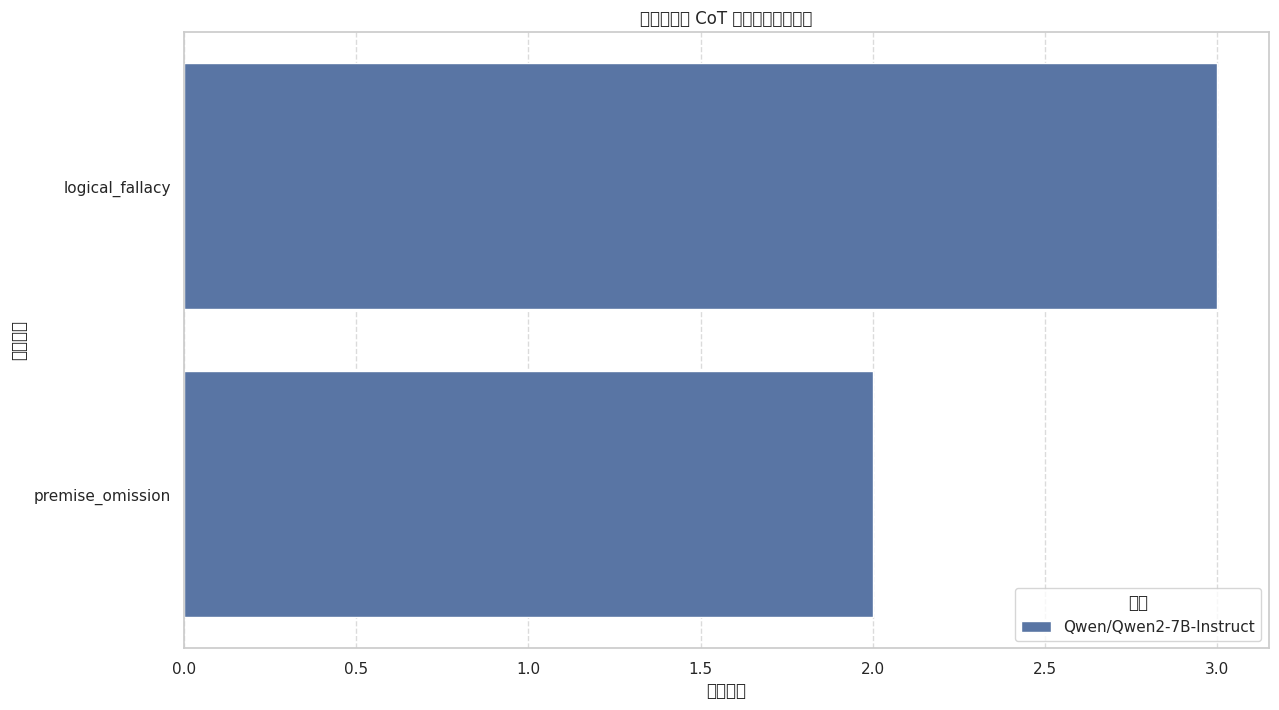

In [17]:
# 检查 detailed_analysis_df 是否存在且不为空
if 'detailed_analysis_df' in globals() and not detailed_analysis_df.empty:
    # 筛选出存在错误的样本
    error_df = detailed_analysis_df[
        (detailed_analysis_df['error_type'] != 'correct') & 
        (detailed_analysis_df['error_type'] != 'parse_error')
    ].copy()

    if not error_df.empty:
        plt.figure(figsize=(14, 8))
        sns.countplot(data=error_df, y='error_type', hue='model', order=error_df['error_type'].value_counts().index)
        
        plt.title('不同模型的 CoT 推理错误类型分布')
        plt.xlabel('错误数量')
        plt.ylabel('错误类型')
        plt.legend(title='模型')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("在评估的样本中未发现明确的推理错误。")
else:
    print("评估数据框 'detailed_analysis_df' 不存在或为空，无法进行错误分析。")
